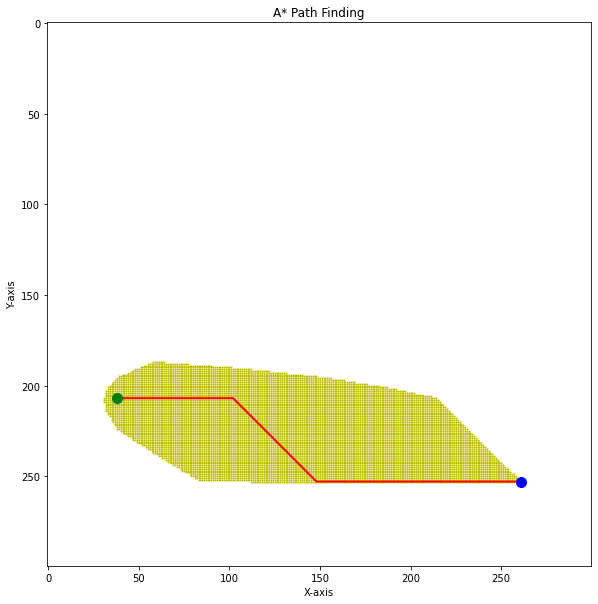

len path :  224
cell added (space):  [213 228]
cell added (space):  [368 237]
65[array([ 58, 194]), array([213, 228]), array([368, 237]), array([404, 237])]
IN: d= 73.26852871290545  angle= 92.176806406945
omega =  6.435155063098378
after omega: w_ml, w_mr :  30.807431463583846 3.2709539842791573
v_ml :  331.17988823352636 v_mr :  35.162755331000945
v_m =  {'motor.left.target': [331], 'motor.right.target': [35]}
IN: d= 73.30341666398341  angle= 84.7451615478119
omega =  5.916328376575247
after omega: w_ml, w_mr :  29.705497146157136 4.389115255695616
v_ml :  319.3340943211892 v_mr :  47.18298899872787
v_m =  {'motor.left.target': [319], 'motor.right.target': [47]}
IN: d= 73.19473998525453  angle= 73.78511978149814
omega =  5.151173116662166
after omega: w_ml, w_mr :  28.043147129894525 6.000917979526187
v_ml :  301.46383164636615 v_mr :  64.5098682799065
v_m =  {'motor.left.target': [301], 'motor.right.target': [64]}
IN: d= 72.74992330934329  angle= 66.54307324288914
omega =  4.6455828

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from final_camera_class import *
from final_Thymio_class import *
from final_path import *
from motion import *

###########################################################
#Parameters
###########################################################
camera_index=1 #0 if no webcam
corner_aruco_id=[0, 1, 2, 10] #top-left, bottom-left, bottom-right, top-right
corner_aruco_size=65 #mm
min_size=500 #minimum blob size
thresh_obstacle=np.array([[40,20,120,65,50,160]]) #BGR
thresh_goal=np.array([40,40,20,60,150,65]) #BGR
Thymio_id=9
grid_size=300 #blocks? TBD numbers of blocks or pixels?
ANGLE_THRESHOLD = np.radians(40)   #threshold under which changes of directions are ignored [rad]
STEP = 10                           #step (in number of cells) between each cell we study
COUNTER_THRESHOLD = 10              #max number of steps between keypoints
keypoint_dist_thresh=1 #pix TBD

###########################################################
#Main Code
###########################################################
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

async def main():
    
    #Camera initialization
    cam=camera_class(camera_index,corner_aruco_id,corner_aruco_size,min_size, thresh_obstacle, thresh_goal)

    #Thymio initialization
    Thymio=Thymio_class(Thymio_id,cam.persp_image)


    Path_planning=True #We want to have the path
    step = 0
    
    while True :
        step = step + 1
        #Update Image
        cam.get_image()
        cam.correct_perspective_aruco(get_matrix=False)
        #Path Planning
        if Path_planning:
            if Thymio.target_keypoint==None: #only possible at first iteration to not take time later
                do_plot=True
            grid=discretize_image_eff(cam.thresholded_image,grid_size)
            #Careful! Image frame's first coord (x) is pointing right but in a matrix the first coordinate (rows) is pointing down so they must be inverted
            path, _, _ = a_star_search(grid, grid1_coord2grid2_coord(np.array([Thymio.xytheta_est[1],Thymio.xytheta_est[0]]),cam.persp_image,grid), grid1_coord2grid2_coord(np.array([cam.goal_center[1],cam.goal_center[0]]),cam.persp_image,grid),do_plot)

            # Convert path coordinates for plotting
            path_img = grid1_coord2grid2_coord(path, grid, cam.persp_image)
            path_img = path_img[::-1]
            
            keypoints=find_keypoints(path_img,ANGLE_THRESHOLD,STEP,COUNTER_THRESHOLD)
            print(f"65{keypoints}")
            #keypoints=keypoints[np.linalg.norm(keypoints-Thymio.xytheta_est[:2].reshape(2,1),axis=1)<keypoint_dist_thresh,:] #Keep only far keypoints
            #print(f"67{keypoints}")
            #Thymio.target_keypoint=Thymio.keypoints[0,:]
            #Thymio.keypoints=keypoints[1:,:]
            do_plot=False
            Path_planning=False

        #Thymio Position and motor 
        Thymio.Thymio_position_aruco(cam.persp_image)
        Thymio.delta_time_update()
        #TBD await get motor speed something
        if((step % 5)==0) :
            x_cm, y_cm, theta_rad, x_goal_cm, y_goal_cm = adjust_units(Thymio.xytheta_meas, Thymio.target_keypoint, cam.pixbymm)
            v_m = motion_control(x_cm, y_cm, theta_rad, x_goal_cm, y_goal_cm)
            #print("x_cm = ", x_cm, " y_cm = ", y_cm)
            print ("v_m = ", v_m)
            await node.set_variables(v_m)
            draw_on_image(cam,Thymio,path_img)
            
            

#         if Thymio.Thymio_detected:
#             #TBD Thymio.kalmanfilter_detected don't forget variance of kalman filter in plot!!
#             pass
#         else:
#             #TBD Thymio.kalmanfilter_not_detected
#             pass

#         #Obstacle detection
#         #TBD await get oprox sensor data
#         obstacle=False #TBD
#         if obstacle:
#             Thymio.local_avoidance=True
#             #TBD Thymio.local avoidance to update target motor speed
#             #TBD await set speed (thymio.speed)
#             draw_on_image(cam,Thymio,path_img)
#             continue
#         else:
#             if Thymio.local_avoidance:
#                 Path_planning=True
#                 draw_on_image(cam,Thymio,path_img)
#                 continue
#         #Target Achieved?
#             else:
#                 if np.linalg.norm(Thymio.xytheta_est[:2]-Thymio.target_keypoint)<keypoint_dist_thresh:
#                     if Thymio.keypoints.size==0:
#                         print("Goal Achieved!")
#                         break
#                     else: #Update target
#                         Thymio.target_keypoint=Thymio.keypoints[0,:]
#                         Thymio.keypoints=Thymio.keypoints[1:,:]
#                 #Controller:
#                 #TBD Thymio.astolfi get speed and set them
#                 draw_on_image(cam,Thymio,path_img)
    # cam.cam.release()
    # cv2.destroyAllWindows()

# Run the main asynchronous function
client.run_async_program(main)
aw(node.stop())
aw(node.unlock())

In [ ]:
# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
cam.cam.release()

In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

# Stop the program
aw(node.stop())
aw(node.unlock())